# Automated stock market analysis by sector

__Developer:__ Riccardo Poli (https://www.linkedin.com/in/riccardopoli/)

__Description:__ this Jupyter notebook enables the user to perform an automated stock market analysis for the sector of interest. The assessment is made against the performance of each stock at the beginning of the year, 2020.

__Version control:__ Initial release: 1.0 (12 Jul 2020). Current version: 1.1 (23 Dec 2020)

In [1]:
## Import required libraries
import yfinance as yf
import pandas as pd
from bokeh.plotting import figure
import bokeh.models as bmo
from bokeh.palettes import Paired11
from bokeh.io import show
from bokeh.models import ColumnDataSource, HoverTool
import math


__Input definition__

The user has to define two inputs:
- __depth__: the level of detail of the analysis. This can either be "sector" or "sub_sector". If you select "sector", you do not need to specify any other input and you can set the variable __filter = ''__ 
- __filter__: the sector of interest, to be specified only if performing a "sub_sector" analysis. The available sectors are: *Communication Services*, *Consumer Discretionary*, *Consumer Staples*, *Energy*, *Financials*, *Health Care*, *Industrials*, *Information Technology*, *Materials*, *Real Estate* and *Utilities*


In [16]:
# Input definition
depth = 'sub_sector'
filter = 'Health Care'


__Main body__

The stock prices at the end of each trasing session for each S&P 500 stock are downloaded throught the Yahoo finance API (free, and no API key needed). The typical run time is in the order of few minutes, depending on the download speed.

A full list of the 500 stocks of the S&P 500 can be found at https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks


In [3]:
# Main body
index_name = 'SP_500'
companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', flavor='bs4')[0]
code_label = 'Symbol'
company_label = 'Security'

companies_codes = companies[code_label].to_list()

df_all = pd.DataFrame()
color_df = pd.DataFrame({0})

for stock in companies_codes:

    try:
        stock_data = yf.Ticker(stock.replace(".",""))
        stock_name = companies[company_label].loc[companies[code_label] == stock].values[0]
        df_all[stock_name] = stock_data.history(start="2017-01-01")['Close']

        color_df[stock_name] = 'blue'

    except:
        pass

color_df = color_df.drop(columns=[0])

df_all = df_all.loc[df_all.index > '2019' ,:]

df_ytd = df_all.loc[df_all.index > '2020' ,:]
df_hist = df_all.loc[df_all.index < '2020' ,:]

df_ytd_pc = (df_ytd.iloc[-1, :] - df_ytd.iloc[0, :]) / df_ytd.iloc[0, :] * 100

df_hist_pc = df_hist.pct_change()*100
std_stocks = df_hist_pc.std()

col_names = ['Name', 'YTD_performance', 'Typical_volatility', 'Sector', 'SubSector']
df_summary = pd.DataFrame(columns=col_names)

for stock in std_stocks.index.values:

    name = stock
    pc_change = df_ytd_pc[companies['Security'].loc[companies['Security'] == stock]].values[0]
    volatility = std_stocks[companies['Security'].loc[companies['Security'] == stock]].values[0]
    sector = companies['GICS Sector'].loc[companies['Security'] == stock].values[0]
    sub_sector = companies['GICS Sub-Industry'].loc[companies['Security'] == stock].values[0]

    new_row = pd.DataFrame([[name, pc_change, volatility, sector, sub_sector]], columns=col_names)
    df_summary = df_summary.append(new_row)


source = ColumnDataSource(data=dict(cum_sum_ytd=df_summary.YTD_performance, std=df_summary.Typical_volatility,
                                    sector=df_summary.Sector, sub_sector=df_summary.SubSector, name=df_summary.Name,
                                    ))



__Plots__

The plots are generated throught the Bokeh library in *html* format and will be displayed in a new window. 
Depending on the selected inputs, the code will generate one of the following:

- Sector analysis
    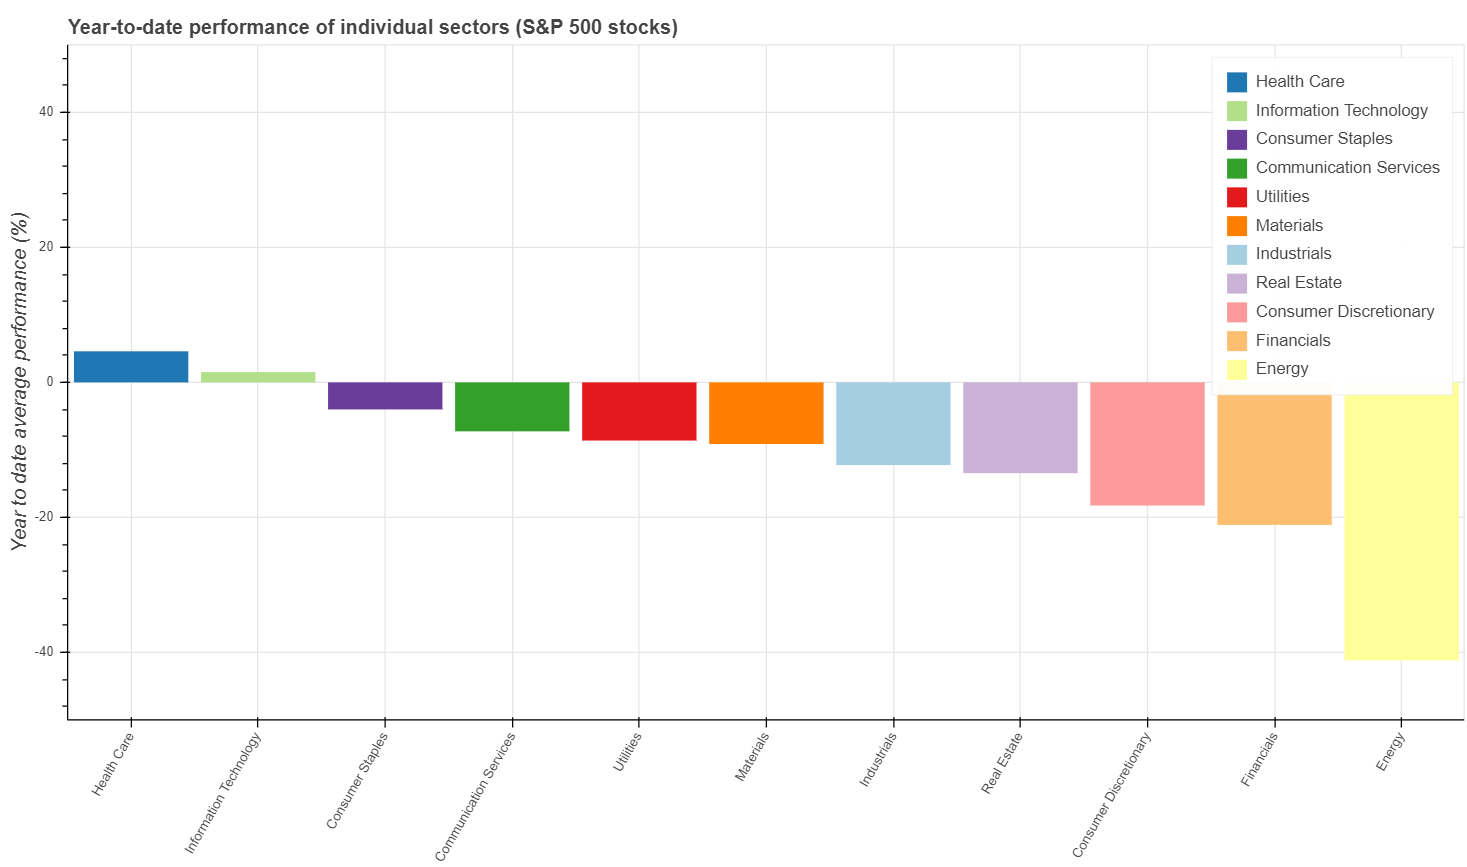


- Sub Sector analysis (sector = "Materials")
    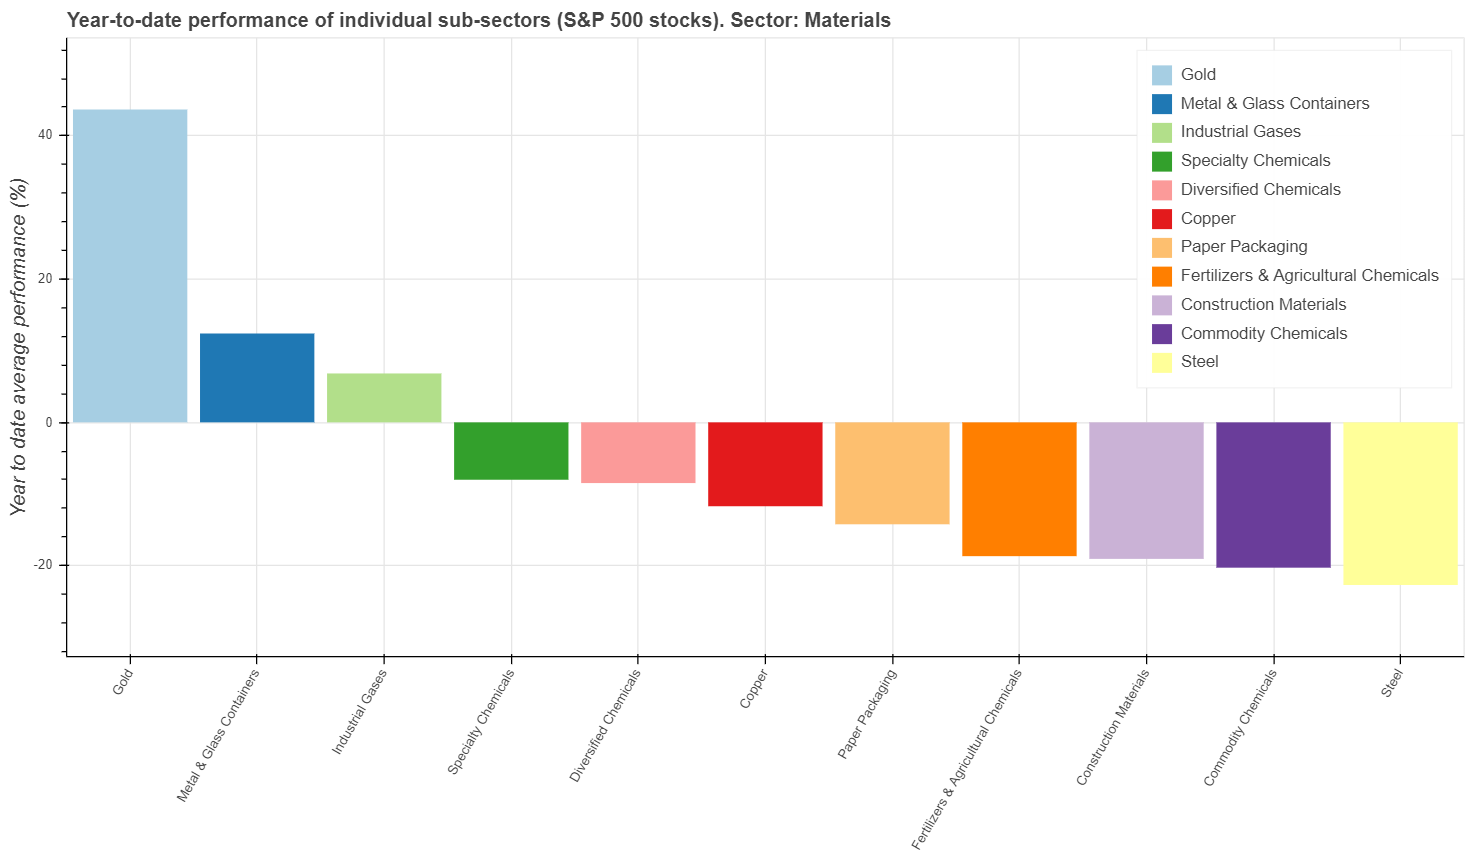

In [17]:
# PLOTS 

if depth == 'sector':

    df_sector = df_summary.groupby(['Sector']).mean()
    df_sector = df_sector.sort_values(by=['YTD_performance'], ascending=False)

    source2 = ColumnDataSource(data=dict(cum_sum_ytd=df_sector.YTD_performance.to_list(), sector=df_sector.index.to_list()))

    p = figure(plot_height=700, plot_width=1200, x_range=df_sector.index.to_list(), toolbar_location='right', y_range=[-50, 50],
               title='Year-to-date performance of individual sectors (S&P 500 stocks)', tools="save")

    color_map = bmo.CategoricalColorMapper(factors=df_summary['Sector'].unique(), palette=Paired11)

    p.vbar(x='sector', top='cum_sum_ytd', width=0.9, source=source2, fill_color={'field': 'sector', 'transform': color_map},
            legend_label='sector', line_width=0)

    p.xaxis.major_label_orientation = math.pi/3
    p.yaxis.axis_label = 'Year to date average performance (%)'

    p.title.text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'

    show(p)


elif depth == 'sub_sector':

    df_sub_sector_pre = df_summary.loc[df_summary['Sector'] == filter]
    df_sub_sector_pre = df_sub_sector_pre.groupby(['SubSector']).mean()
    df_sub_sector_pre = df_sub_sector_pre.sort_values(by=['YTD_performance'], ascending=False)

    if len(df_sub_sector_pre) > 11:
        sliced_df = df_sub_sector_pre.head(5)
        df_sub_sector = sliced_df.append(df_sub_sector_pre.tail(6))
    else:
        df_sub_sector = df_sub_sector_pre

    source3 = ColumnDataSource(data=dict(cum_sum_ytd=df_sub_sector.YTD_performance.to_list(), sector=df_sub_sector.index.to_list()))

    color_map = bmo.CategoricalColorMapper(factors=df_sub_sector.index.unique(), palette=Paired11)

    p = figure(plot_height=700, plot_width=1200, x_range=df_sub_sector.index.to_list(), toolbar_location='right', tools="save",
               title='Year-to-date performance of individual sub-sectors (S&P 500 stocks). Sector: ' + filter,
               y_range=[min(df_sub_sector.YTD_performance.to_list()) - 10, max(df_sub_sector.YTD_performance.to_list()) + 10])

    p.vbar(x='sector', top='cum_sum_ytd', width=0.9, source=source3, fill_color={'field': 'sector', 'transform': color_map},
            legend_label='sector', line_width=0)

    p.xaxis.major_label_orientation = math.pi/3
    p.yaxis.axis_label = 'Year to date average performance (%)'

    p.title.text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'
    p.legend.location = 'top_right'

    show(p)

,Name,YTD_performance,Typical_volatility,Sector,SubSector
0,3M Company,0.714533,1.579011,Industrials,Industrial Conglomerates
0,Abbott Laboratories,26.495327,1.227817,Health Care,Health Care Equipment
0,AbbVie Inc.,21.154979,1.707865,Health Care,Pharmaceuticals
0,ABIOMED Inc,79.094840,3.171582,Health Care,Health Care Equipment
0,Accenture plc,25.450853,1.063831,Information Technology,IT Consulting & Other Services
...,...,...,...,...,...
0,Yum! Brands Inc,7.142857,0.979281,Consumer Discretionary,Restaurants
0,Zebra Technologies,46.623447,2.398192,Information Technology,Electronic Equipment & Instruments
0,Zimmer Biomet,1.733441,1.377105,Health Care,Health Care Equipment
0,Zions Bancorp,-16.801900,1.583207,Financials,Regional Banks
